### TPC Benchmark - Summarize & Plot  
Note: NB_06, NB_07 and NB_08 use shared variables. Run in order 6, 7, 8.

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import config

In [2]:
%store -r results_dir

In [3]:
sf_results_csv_fp = glob.glob(results_dir + config.sep + "benchmark_times_sf*.csv")[0]
sf_results_csv_fp

'/home/colin/code/bq_snowflake_benchmark/results/results_bqsf_ds_100GB_01_test-01_2020-07-10_09:32:27.385122/benchmark_times_sf_ds_100GB_01_test-01_2020-07-10_09:32:27.385122.csv'

In [4]:
bq_results_csv_fp = glob.glob(results_dir + config.sep + "benchmark_times_bq*.csv")[0]
bq_results_csv_fp

'/home/colin/code/bq_snowflake_benchmark/results/results_bqsf_ds_100GB_01_test-01_2020-07-10_09:32:27.385122/benchmark_times_bq_ds_100GB_01_test-01_2020-07-10_09:32:27.385122.csv'

In [5]:
%store -r df_sf_history_sq
%store -r df_sf_history_av
%store -r df_bq_history

In [6]:
dfsf = pd.read_csv(sf_results_csv_fp)
dfbq = pd.read_csv(bq_results_csv_fp)

In [7]:
def row_extract_sf(row, value):
    """Extract Arbitrary row value from
    Snowflake Account Usage table
    
    Parameters
    ----------
    row : Pandas Series, from Snowflake history account view
    value : str, name of column in row
    
    Returns
    -------
    single value or None if nothing found
    """
    mask = df_sf_history_av.QUERY_ID == row["qid"]
    out = df_sf_history_av.loc[mask, value]
    if out.values.shape == (1,):
        return out.values[0]
    else:
        return None

In [8]:
def row_extract_bq(row, value):
    """Extract Arbitrary row value from
    BigQuery Account Usage table
    
    Parameters
    ----------
    row : Pandas Series, from BigQuery history account view
    value : str, name of column in row
    
    Returns
    -------
    single value or None if nothing found
    """
    mask = df_bq_history.job_id == row["qid"]
    out = df_bq_history.loc[mask, value]
    if out.values.shape == (1,):
        return out.values[0]
    else:
        return None

In [9]:
def bytes_to_TebiByte(b):
    return b / 1099511627776

#### Snowflake

In [10]:
sf_keep = ["QUERY_ID", "QUERY_TEXT", "DATABASE_NAME", "WAREHOUSE_SIZE", "WAREHOUSE_TYPE",
             "QUERY_TAG", "START_TIME", "END_TIME", "TOTAL_ELAPSED_TIME", "BYTES_SCANNED",
             "CREDITS_USED_CLOUD_SERVICES"]

In [11]:
sf_extended_keep = sf_keep + ["PERCENTAGE_SCANNED_FROM_CACHE", 
                             "PARTITIONS_SCANNED", "PARTITIONS_TOTAL", 
                             "BYTES_SPILLED_TO_LOCAL_STORAGE", "BYTES_SPILLED_TO_REMOTE_STORAGE"]

In [12]:
for col in sf_extended_keep:
    dfsf[col.lower()] = None
    
for col in sf_extended_keep:
    dfsf[col.lower()] = dfsf.apply(lambda x: row_extract_sf(row=x, value=col), axis=1)

In [13]:
def to_int(x):
    try:
        return int(x)
    except:
        return None

In [14]:
def bytes_to_TebiByte(b):
    if pd.isnull(b):
        return None
    else:
        return b / 1099511627776

In [15]:
def bytes_to_TeraByte(b):
    if pd.isnull(b):
        return None
    else:
        return float(b) / 1e12

In [16]:
def TebiBytes_to_dollars(tib):
    if pd.isnull(tib):
        return None
    else:
        return tib * 5.00

Calculating Costs  
https://www.snowflake.com/blog/how-usage-based-pricing-delivers-a-budget-friendly-cloud-data-warehouse/
https://www.snowflake.com/pricing/



In [17]:
dfsf.dtypes

db                                         object
test                                       object
scale                                       int64
source                                     object
cid                                         int64
desc                                       object
query_n                                     int64
seq_n                                       int64
driver_t0                                  object
driver_t1                                  object
qid                                        object
query_id                                   object
query_text                                 object
database_name                              object
warehouse_size                             object
warehouse_type                             object
query_tag                                  object
start_time                         datetime64[ns]
end_time                           datetime64[ns]
total_elapsed_time                         object


In [18]:
dfsf["dt"] = dfsf.end_time - dfsf.start_time
dfsf["dt_s"] = dfsf.dt.dt.total_seconds()
dfsf["Tib"] = dfsf.bytes_scanned.apply(to_int)
dfsf["TB"] = dfsf.bytes_scanned.apply(bytes_to_TeraByte)

In [19]:
# on demand billing
dfsf["cost_store_od"] = (dfsf.scale / 1000) * 40

dfsf["cost_comp_od_std"] = dfsf.credits_used_cloud_services * 2
dfsf["cost_comp_od_ent"] = dfsf.credits_used_cloud_services * 3
dfsf["cost_comp_od_bus"] = dfsf.credits_used_cloud_services * 4

#### BigQuery

In [20]:
dfbq

,db,test,scale,source,cid,desc,query_n,seq_n,driver_t0,driver_t1,qid
0,bq,ds,100,ds_100GB_01,1,test-01,83,1,2020-07-10 16:45:53.399583+00:00,2020-07-10 16:45:58.629848+00:00,e0e08bea-1403-44cb-872b-e5c26ec6d0a2
1,bq,ds,100,ds_100GB_01,1,test-01,32,1,2020-07-10 16:45:58.648533+00:00,2020-07-10 16:46:00.869266+00:00,8d8c1f28-0404-488f-8754-82c08f20c31a
2,bq,ds,100,ds_100GB_01,1,test-01,30,1,2020-07-10 16:46:00.895820+00:00,2020-07-10 16:46:11.285873+00:00,e56e6ef8-12ce-49d3-9395-2a38af51b0c4
3,bq,ds,100,ds_100GB_01,1,test-01,92,1,2020-07-10 16:46:11.329175+00:00,2020-07-10 16:46:14.590580+00:00,e3291dd2-9780-4c96-bcef-0eb79767fa8b
4,bq,ds,100,ds_100GB_01,1,test-01,66,1,2020-07-10 16:46:14.604294+00:00,2020-07-10 16:46:16.826646+00:00,5cd67a9d-074e-4fa9-a8df-3c0f534591f5
5,bq,ds,100,ds_100GB_01,1,test-01,84,1,2020-07-10 16:46:16.892363+00:00,2020-07-10 16:46:21.554191+00:00,d4d754f9-0da8-477d-b3de-298d9d879f4e
6,bq,ds,100,ds_100GB_01,1,test-01,98,1,2020-07-10 16:46:21.567569+00:00,2020-07-10 16:46:28.288112+00:00,79b7dc63-d684-49f7-8038-1db62246d984
7,bq,ds,100,ds_100GB_01,1,test-01,58,1,2020-07-10 16:46:28.643916+00:00,2020-07-10 16:46:32.804161+00:00,70ec6783-31dd-4bbe-a27e-018792d3fb54
8,bq,ds,100,ds_100GB_01,1,test-01,16,1,2020-07-10 16:46:32.833393+00:00,2020-07-10 16:46:36.095947+00:00,ab8e450f-ec33-4efe-9248-681f0344fb8e
9,bq,ds,100,ds_100GB_01,1,test-01,77,1,2020-07-10 16:46:36.121624+00:00,2020-07-10 16:46:39.375147+00:00,43967098-59f8-48ef-991d-cb85cdbaeb73


In [21]:
df_bq_history

,creation_time,project_id,project_number,user_email,job_id,job_type,statement_type,start_time,end_time,query,state,reservation_id,total_bytes_processed,total_slot_ms,error_result,cache_hit,destination_table,referenced_tables,labels,timeline,job_stages
0,2020-07-10 16:47:40.032000+00:00,tpc-benchmarking-9432,476262002685,tpc-service-account-2@tpc-benchmarking-9432.ia...,cee20f95-ecff-4b05-9592-a4590d541101,QUERY,SELECT,2020-07-10 16:47:40.189000+00:00,2020-07-10 16:47:40.690000+00:00,\nselect distinct(i_product_name)\n from item...,DONE,None,14945614,384,None,False,"{'project_id': 'tpc-benchmarking-9432', 'datas...","[{'project_id': 'tpc-benchmarking-9432', 'data...","[{'key': 'label', 'value': 'ds_100gb_01-q41-1-...","[{'elapsed_ms': 477, 'total_slot_ms': 384, 'pe...","[{'name': 'S00: Input', 'id': 0, 'start_ms': 1..."
1,2020-07-10 16:46:44.046000+00:00,tpc-benchmarking-9432,476262002685,tpc-service-account-2@tpc-benchmarking-9432.ia...,57714a80-e57d-4938-a021-f4ebd697f176,QUERY,SELECT,2020-07-10 16:46:44.198000+00:00,2020-07-10 16:46:44.849000+00:00,\nselect \n\tcount(*) as r1\nfrom store_sales\...,DONE,None,6602940020,63047,None,False,"{'project_id': 'tpc-benchmarking-9432', 'datas...","[{'project_id': 'tpc-benchmarking-9432', 'data...","[{'key': 'label', 'value': 'ds_100gb_01-q96-1-...","[{'elapsed_ms': 622, 'total_slot_ms': 63047, '...","[{'name': 'S00: Input', 'id': 0, 'start_ms': 1..."
2,2020-07-10 16:52:17.280000+00:00,tpc-benchmarking-9432,476262002685,tpc-service-account-2@tpc-benchmarking-9432.ia...,9135d0c4-71bf-40a0-b1fc-a9618a96ab79,QUERY,SELECT,2020-07-10 16:52:17.499000+00:00,2020-07-10 16:52:18.276000+00:00,"\nselect i_brand_id brand_id, i_brand brand,\...",DONE,None,6714733437,75195,None,False,"{'project_id': 'tpc-benchmarking-9432', 'datas...","[{'project_id': 'tpc-benchmarking-9432', 'data...","[{'key': 'label', 'value': 'ds_100gb_01-q55-1-...","[{'elapsed_ms': 620, 'total_slot_ms': 75096, '...","[{'name': 'S00: Input', 'id': 0, 'start_ms': 1..."
3,2020-07-10 16:51:18.464000+00:00,tpc-benchmarking-9432,476262002685,tpc-service-account-2@tpc-benchmarking-9432.ia...,85988636-1945-47fc-8af0-8a5f65a68cb4,QUERY,SELECT,2020-07-10 16:51:18.605000+00:00,2020-07-10 16:51:19.340000+00:00,"\nselect s_store_name, s_store_id,\n s...",DONE,None,6602557221,77108,None,False,"{'project_id': 'tpc-benchmarking-9432', 'datas...","[{'project_id': 'tpc-benchmarking-9432', 'data...","[{'key': 'label', 'value': 'ds_100gb_01-q43-1-...","[{'elapsed_ms': 617, 'total_slot_ms': 76783, '...","[{'name': 'S00: Input', 'id': 0, 'start_ms': 1..."
4,2020-07-10 16:47:08.711000+00:00,tpc-benchmarking-9432,476262002685,tpc-service-account-2@tpc-benchmarking-9432.ia...,19025228-ebbc-4b91-907f-b31bfa43faee,QUERY,SELECT,2020-07-10 16:47:08.864000+00:00,2020-07-10 16:47:09.692000+00:00,"\nselect dt.d_year \n ,item.i_brand_id ...",DONE,None,6714733453,74555,None,False,"{'project_id': 'tpc-benchmarking-9432', 'datas...","[{'project_id': 'tpc-benchmarking-9432', 'data...","[{'key': 'label', 'value': 'ds_100gb_01-q3-1-t...","[{'elapsed_ms': 628, 'total_slot_ms': 73626, '...","[{'name': 'S00: Input', 'id': 0, 'start_ms': 1..."
5,2020-07-10 17:11:26.959000+00:00,tpc-benchmarking-9432,476262002685,tpc-service-account-2@tpc-benchmarking-9432.ia...,89ed0709-cddb-4532-93cf-b3f10ffd1e6d,QUERY,SELECT,2020-07-10 17:11:27.106000+00:00,2020-07-10 17:11:27.935000+00:00,"\nselect dt.d_year\n \t,item.i_category_id\n ...",DONE,None,6712645644,64358,None,False,"{'project_id': 'tpc-benchmarking-9432', 'datas...","[{'project_id': 'tpc-benchmarking-9432', 'data...","[{'key': 'label', 'value': 'ds_100gb_01-q42-1-...","[{'elapsed_ms': 613, 'total_slot_ms': 63570, '...","[{'name': 'S00: Input', 'id': 0, 'start_ms': 1..."
6,2020-07-10 16:48:23.369000+00:00,tpc-benchmarking-9432,476262002685,tpc-service-account-2@tpc-benchmarking-9432.ia...,7709c3c9-6523-4f77-969e-f515dac85794,QUERY,SELECT,2020-07-10 16:48:23.539000+00:00,2020-07-10 16:48:24.250000+00:00,"\nselect dt.d_year\n 

In [22]:
bq_keep = ["statement_type", "start_time", "end_time", "total_bytes_processed", 
           "total_slot_ms",  "cache_hit", "labels"]

In [23]:
for col in bq_keep:
    dfbq[col.lower()] = None
    
for col in bq_keep:
    dfbq[col.lower()] = dfbq.apply(lambda x: row_extract_bq(row=x, value=col), axis=1)

In [24]:
dfbq.dtypes

db                               object
test                             object
scale                             int64
source                           object
cid                               int64
desc                             object
query_n                           int64
seq_n                             int64
driver_t0                        object
driver_t1                        object
qid                              object
statement_type                   object
start_time               datetime64[ns]
end_time                 datetime64[ns]
total_bytes_processed             int64
total_slot_ms                     int64
cache_hit                          bool
labels                           object
dtype: object

In [25]:
dfbq.start_time = pd.to_datetime(dfbq.start_time)
dfbq.end_time = pd.to_datetime(dfbq.end_time)

In [26]:
dfbq["dt"] = dfbq.end_time - dfbq.start_time
dfbq["dt_s"] = dfbq.dt.dt.total_seconds()
dfbq["Tib"] = dfbq.total_bytes_processed.apply(bytes_to_TebiByte)
dfbq["TB"] = dfbq.total_bytes_processed.apply(bytes_to_TeraByte)

Calculating Costs  
https://cloud.google.com/bigquery/pricing  


In [27]:
dfbq["cost_comp"] = dfbq.TB * 5.00

#### Combine

In [28]:
common = ["db", "test", "scale", "source", "cid", "desc", "query_n", "seq_n", "dt", "dt_s", "TB"]

In [29]:
dfsf_short = dfsf[common] # + ["percentage_scanned_from_cache"]]

In [30]:
dfbq_short = dfbq[common]

In [31]:
df = pd.concat([dfsf_short, dfbq_short])
df.reset_index(inplace=True, drop=True)

In [32]:
df.dtypes

db                  object
test                object
scale                int64
source              object
cid                  int64
desc                object
query_n              int64
seq_n                int64
dt         timedelta64[ns]
dt_s               float64
TB                 float64
dtype: object

### Query Stream Result  

In [33]:
test = df.loc[0, "test"]
scale = df.loc[0, "scale"]
query_stream_number = df.loc[0, "seq_n"]
df_summary = df[["db", "test", "dt_s", "TB"]].groupby(by=["db", "test"]).sum()

In [34]:
print("Test: TPC-{}".format(test.upper()))
print("Scale Factor: {}GB".format(scale))
print("Query Stream Number: {}".format(query_stream_number))
print()
print("Key:")
print("  ds_s: elapsed time in seconds")
print("  TB: data processed in Terabytes")
print()
print("Summary:")
print(df_summary)


Test: TPC-DS
Scale Factor: 100GB
Query Stream Number: 1

Key:
  ds_s: elapsed time in seconds
  TB: data processed in Terabytes

Summary:
             dt_s        TB
db test                    
bq ds    1394.740  1.038760
sf ds     695.256  0.220954


In [35]:
meta_data = bq_results_csv_fp.split(config.sep)[-1].split("_")
meta_data

['benchmark',
 'times',
 'bq',
 'ds',
 '100GB',
 '01',
 'test-01',
 '2020-07-10',
 '09:32:27.385122.csv']

In [36]:
df_summary.reset_index(inplace=True)
df_summary.db = df_summary.db.str.upper()
df_summary.test = df_summary.test.str.upper()
df_summary["scale"] = meta_data[4]
df_summary["desc"] = meta_data[6]

In [37]:
df_summary

,db,test,dt_s,TB,scale,desc
0,BQ,DS,1394.740,1.038760,100GB,test-01
1,SF,DS,695.256,0.220954,100GB,test-01


In [38]:
summary_fp = results_dir + config.sep + "benchmark_summary_" + "_".join(meta_data[3:])

In [39]:
df_summary.to_csv(summary_fp, index=False)

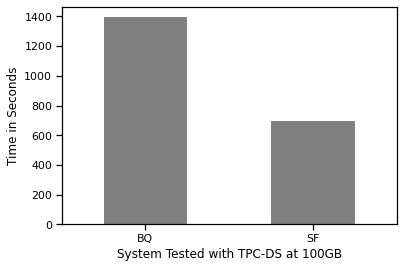

In [40]:
ax = df_summary[["db", "dt_s"]].plot.bar(x="db", rot=0, color="grey")
ax.set_xlabel("System Tested with TPC-{} at {}GB".format(test.upper(), scale))
ax.set_ylabel("Time in Seconds")
ax.get_legend().remove();

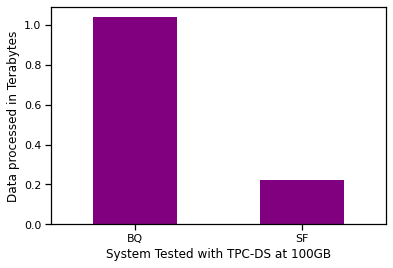

In [41]:
ax = df_summary[["db", "TB"]].plot.bar(x="db", rot=0, color="purple")
ax.set_xlabel("System Tested with TPC-{} at {}GB".format(test.upper(), scale))
ax.set_ylabel("Data processed in Terabytes")
ax.get_legend().remove();

### Per-Query Results

In [42]:
df

,db,test,scale,source,cid,desc,query_n,seq_n,dt,dt_s,TB
0,sf,ds,100,ds_100GB_01,1,test-01,83,1,00:00:05.929000,5.929,2.184644e-04
1,sf,ds,100,ds_100GB_01,1,test-01,32,1,00:00:01.144000,1.144,5.198045e-05
2,sf,ds,100,ds_100GB_01,1,test-01,30,1,00:00:03.051000,3.051,1.607246e-04
3,sf,ds,100,ds_100GB_01,1,test-01,92,1,00:00:05.739000,5.739,9.967237e-04
4,sf,ds,100,ds_100GB_01,1,test-01,66,1,00:00:06.292000,6.292,1.109431e-03
5,sf,ds,100,ds_100GB_01,1,test-01,84,1,00:00:01.788000,1.788,1.223759e-04
6,sf,ds,100,ds_100GB_01,1,test-01,98,1,00:00:15.524000,15.524,1.958698e-03
7,sf,ds,100,ds_100GB_01,1,test-01,58,1,00:00:02.515000,2.515,2.336888e-03
8,sf,ds,100,ds_100GB_01,1,test-01,16,1,00:00:02.599000,2.599,1.566060e-04
9,sf,ds,100,ds_100GB_01,1,test-01,77,1,00:00:09.690000,9.690,3.198438e-03


In [43]:
dfp_dt = df.pivot(index="query_n", columns="db", values="dt_s")
dfp_bp = df.pivot(index="query_n", columns="db", values="TB")

### Plot Results

In [44]:
sns.set_style("darkgrid", {"xtick.bottom":True})

In [45]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set2 = sns.color_palette("Set2", 8)
hls = sns.hls_palette(n_colors=12)

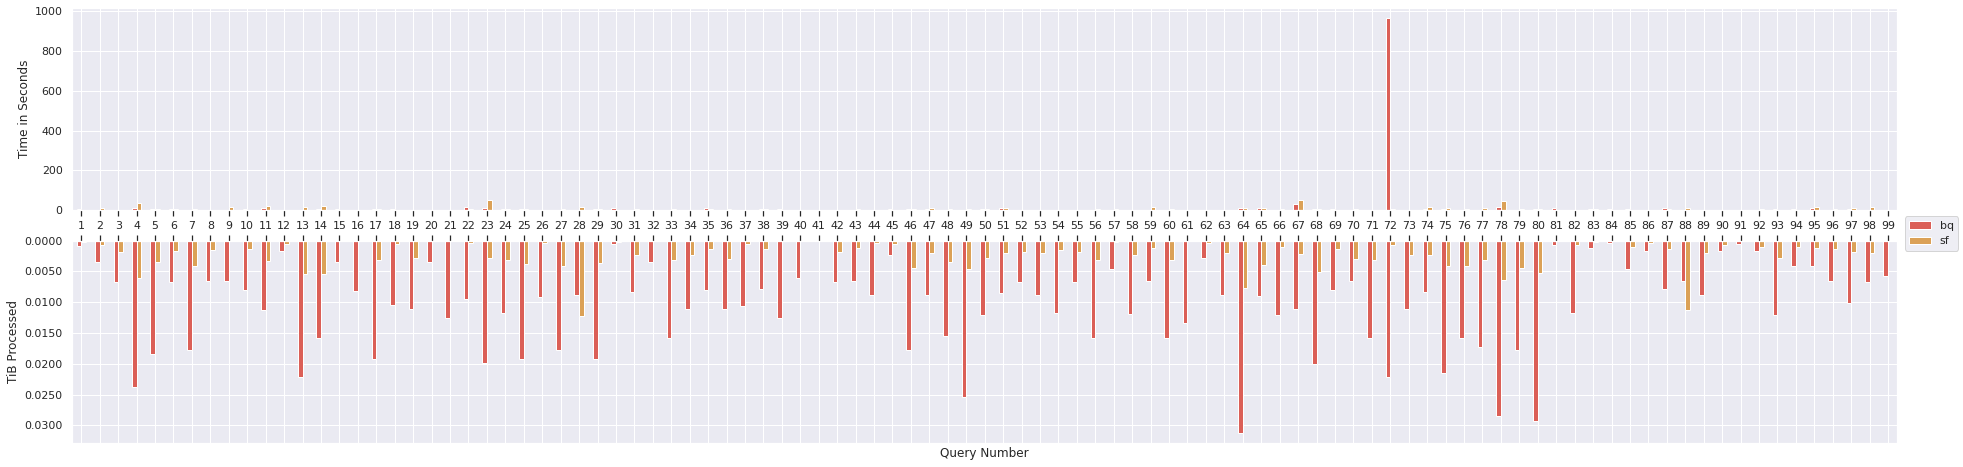

In [61]:
plot_name = "{}_{}_comparison.png".format(dfsf.loc[0, "source"], dfsf.loc[0, "desc"])
#plot_name = "Test Bar"

color_palette = hls
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1 = dfp_dt.plot.bar(ax=ax1, legend=False, color=color_palette)

# invert bytes processed for plotting
_dfp_bp = dfp_bp.copy() * -1
ax2 = _dfp_bp.plot.bar(ax=ax2, legend=False, color=color_palette);

# set the figure size BEFORE adjusting ticks
fig.set_size_inches(30, 8, forward=True)

handles, labels = ax1.get_legend_handles_labels()

ax1.set_ylabel("Time in Seconds")
ax1.set_xlabel(None)
ax1_xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels(labels=[])

ax2.set_ylabel("TiB Processed")
ax2.set_xlabel("Query Number")
ticks =  ax2.get_yticks()
ticks = ["{:01.4f}".format(abs(tick)) for tick in ticks]
ax2.set_yticklabels(ticks);
ax2.xaxis.tick_top()

plt.subplots_adjust(hspace=0.15)
plt.subplots_adjust(right=0.97)

fig.legend(handles, labels, loc="right")
plt.savefig(results_dir + config.sep + plot_name, bbox_to_anchor='tight')
print();

### Selective Filter Query Results

In [55]:
# Notes for now: 
# 72 is slow, by like 10 minutes
queries_to_drop = [72]

In [56]:
dfp_dt_limited = dfp_dt.copy()
dfp_bp_limited = dfp_bp.copy()

In [59]:
dfp_dt_limited = dfp_dt_limited.loc[~dfp_dt_limited.index.isin(queries_to_drop)]
dfp_bp_limited = dfp_bp_limited.loc[~dfp_bp_limited.index.isin(queries_to_drop)]

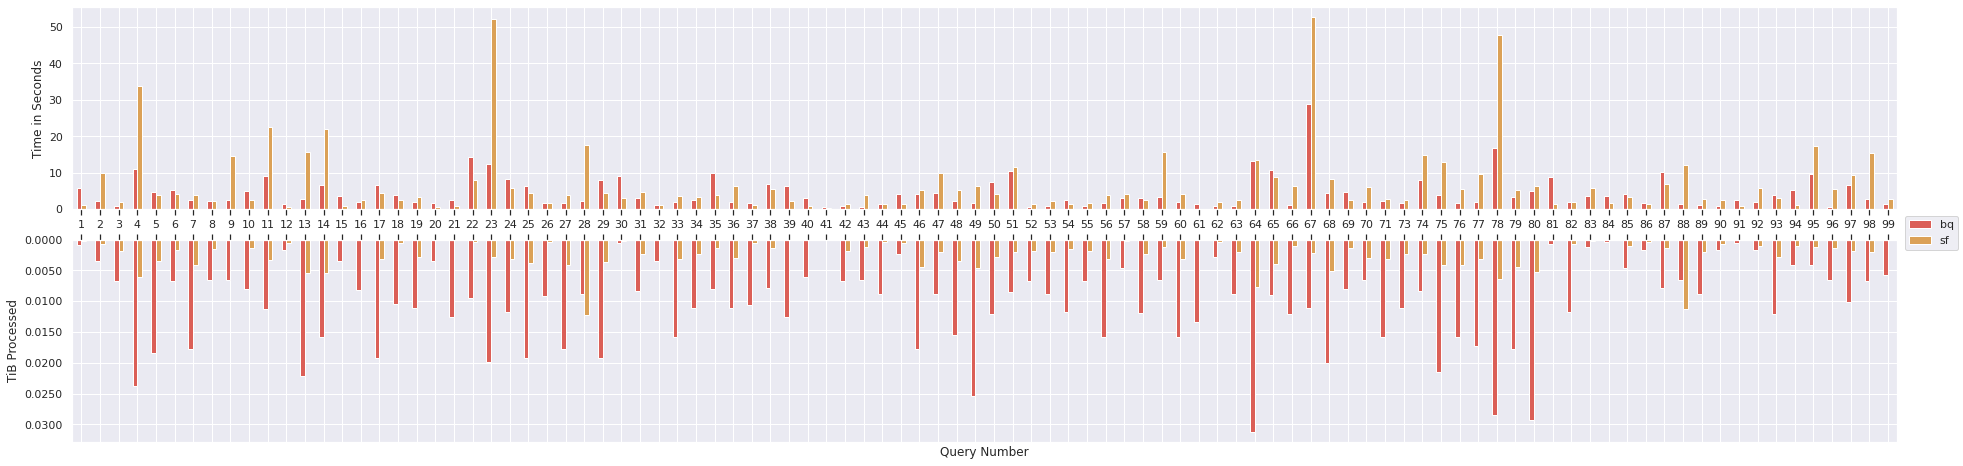

In [62]:
plot_name = "{}_{}_comparison_filtered.png".format(dfsf.loc[0, "source"], dfsf.loc[0, "desc"])
#plot_name = "Test Bar"

color_palette = hls
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1 = dfp_dt_limited.plot.bar(ax=ax1, legend=False, color=color_palette)

# invert bytes processed for plotting
_dfp_bp = dfp_bp_limited.copy() * -1
ax2 = _dfp_bp.plot.bar(ax=ax2, legend=False, color=color_palette);

# set the figure size BEFORE adjusting ticks
fig.set_size_inches(30, 8, forward=True)

handles, labels = ax1.get_legend_handles_labels()

ax1.set_ylabel("Time in Seconds")
ax1.set_xlabel(None)
ax1_xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels(labels=[])

ax2.set_ylabel("TiB Processed")
ax2.set_xlabel("Query Number")
ticks =  ax2.get_yticks()
ticks = ["{:01.4f}".format(abs(tick)) for tick in ticks]
ax2.set_yticklabels(ticks);
ax2.xaxis.tick_top()

plt.subplots_adjust(hspace=0.15)
plt.subplots_adjust(right=0.97)

fig.legend(handles, labels, loc="right")
plt.savefig(results_dir + config.sep + plot_name, bbox_to_anchor='tight')
print();